In [9]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

In [10]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [11]:
def load_data():
    train = pd.read_csv('../input/train.csv')
    test = pd.read_csv('../input/test.csv')
    combined = train.append(test, ignore_index=True).drop(['Id','SalePrice'], axis=1)
    combined = pd.get_dummies(combined)
    combined = combined.fillna(combined.mean())
    y = np.log(train['SalePrice'].values)
    X = combined.iloc[:train.shape[0],:]
    X_submission = combined.iloc[train.shape[0]:,:]
    ids_submission = test['Id'].values
    return y, X, X_submission, ids_submission

In [12]:
# load data
y, X, X_submission, ids_submission = load_data()

In [13]:
parameters = {'max_depth': [5,7,9,11,13,15],
              'learning_rate': [0.5, 0.1, 0.2, 0.3],
              'n_estimators': [100],
              'min_child_weight': [1,2,4,8],
              'subsample': [0.4, 0.6, 0.8],
              'colsample_bytree': [0.4, 0.6, 0.8]}

model = RandomizedSearchCV(XGBRegressor(silent = True, objective='reg:linear', nthread=4, seed = 1337),
                           parameters, 
                           n_iter=60, 
                           random_state=1773,
                           scoring=make_scorer(rmse, greater_is_better=False), 
                           cv=KFold(10, random_state=1773))

In [14]:
%%time
model.fit(X,y)

CPU times: user 15min 38s, sys: 8.79 s, total: 15min 47s
Wall time: 4min


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=1773, shuffle=False),
          error_score='raise',
          estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1337, silent=True, subsample=1),
          fit_params={}, iid=True, n_iter=60, n_jobs=1,
          param_distributions={'colsample_bytree': [0.4, 0.6, 0.8], 'learning_rate': [0.5, 0.1, 0.2, 0.3], 'min_child_weight': [1, 2, 4, 8], 'n_estimators': [100], 'subsample': [0.4, 0.6, 0.8], 'max_depth': [5, 7, 9, 11, 13, 15]},
          pre_dispatch='2*n_jobs', random_state=1773, refit=True,
          return_train_score=True,
          scoring=make_scorer(rmse, greater_is_better=False), verbose=0)

In [15]:
print 'best score:', model.best_score_
print 'best parameters:', model.best_params_

best score: -0.124526475279
best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8, 'max_depth': 5}


In [16]:
# create submission predictions
preds_submission = model.predict(X_submission)

# save submission
pd.DataFrame({'Id': ids_submission, 'SalePrice': np.exp(preds_submission)})\
  .to_csv('../output/07_randomsearch_XGB.csv', index=False)

/Users/dave/.pyenv/versions/anaconda-2.4.0/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


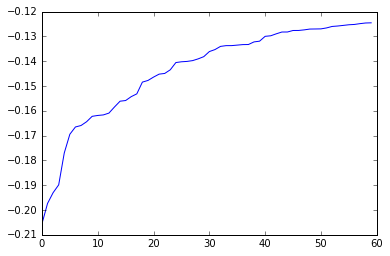

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(np.sort(model.cv_results_['mean_test_score']));